In [1]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:1')
torch.cuda.set_device(device)
import numpy as np
from tqdm.auto import tqdm
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from TNModels import Ising3D

In [8]:
model=Ising3D(Ising3D.get_default_params())
T0=model.get_T0()
T0_op,checkerboard=model.get_observables()['magnetization']

In [9]:
from HOSVD import _HOSVD_layer_3D,gauge_invariant_norm
def _XTRG_layer_3D(Ta,Tb,max_dim):
    Tn,layer=_HOSVD_layer_3D(Ta,Tb,max_dim=max_dim)
    Tn=contract('abcdio->ioabcd',Tn)
    return Tn,layer

def XTRG_3D_defect(T0,T0_op,max_dim,nLayers):
    T,T_op,logTotal=T0,T0_op,0
    for i in tqdm(range(nLayers),leave=False):
        norm=gauge_invariant_norm(T)
        logTotal=2*(logTotal+norm.log())
        T,T_op=T/norm,T_op/norm
        T_op=_XTRG_layer_3D(T_op,T,max_dim=max_dim)[0]
        T=_XTRG_layer_3D(T,T,max_dim=max_dim)[0]
    return T,T_op

T,T_op=XTRG_3D_defect(T0,T0_op,max_dim=16,nLayers=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
Y0=contract('aaijkl->ijkl',T)
Y0_op=contract('aaijkl->ijkl',T_op)

In [13]:
from HOTRGZ2 import forward_observable_tensors,HOTRG_layers,trace_tensor


layers,Ys,logTotals=HOTRG_layers(Y0,max_dim=16,nLayers=30,return_tensors=True)

Generating HOTRG layers


  0%|          | 0/30 [00:00<?, ?it/s]

HOTRG layers generated


In [15]:
filename='./data/ising3d_xtrg_X16_corr'
T0_op,checkerboard=model.get_observables()['magnetization']
data=[]
for r in tqdm(np.geomspace(2,1023,32)):
    theta=np.random.uniform(0,.5*np.pi)
    dx,dy=int(r*np.sin(theta)),int(r*np.cos(theta))
    x1,y1=np.random.randint(0,1024-dx),np.random.randint(0,1024-dy)
    x2,y2=x1+dx,y1+dy
    T,T_op,logTotal=forward_observable_tensors(Y0,[Y0_op,Y0_op],[(x1,y1),(x2,y2)],layers,cached_Ts=Ys,user_tqdm=False)
    corr=trace_tensor(T_op)/trace_tensor(T)
    data.append({'corr':corr.item(),
                 'x1':x1,'y1':y1,
                 'x2':x2,'y2':y2,
    })
# save 
torch.save(data,filename)


  0%|          | 0/32 [00:00<?, ?it/s]

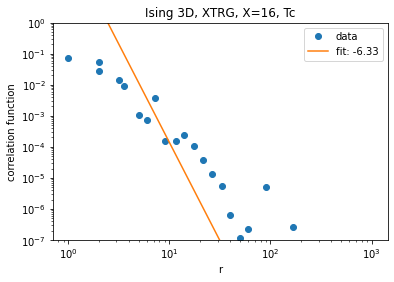

In [16]:
curve=pd.DataFrame(torch.load('./data/ising3d_xtrg_X16_corr'))
curve['r']=np.sqrt((curve['x1']-curve['x2'])**2+(curve['y1']-curve['y2'])**2)

import scipy.stats
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(np.log(curve['r']),np.log(np.abs(curve['corr'])))


plt.plot(curve['r'],np.abs(curve['corr']),'o',label='data')
plt.plot(curve['r'],np.exp(intercept)*curve['r']**slope,label=f'fit: {slope:.2f}')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('correlation function')
plt.ylim([1e-7,1])
plt.title('Ising 3D, XTRG, X=16, Tc')
plt.show()